In [1]:
import pandas as pd
from time import time
from gensim.models.doc2vec import Doc2Vec,TaggedDocument
from gensim.utils import simple_preprocess
import re
from scipy.stats import skew, kurtosis,linregress
from collections import namedtuple, Counter
from sklearn.manifold import TSNE
tsne=TSNE()


from sklearn.cluster import DBSCAN
dbscan=DBSCAN()

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sns
import numpy as np
import random
import json
import matplotlib.pyplot as plt

%matplotlib inline

C:\Users\ionab\Anaconda3\lib\site-packages\gensim\utils.py:1167: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
with open('../creds.json') as f:
    creds = json.load(f)

plotly.tools.set_credentials_file(username='ionab10', api_key=creds['Plotly'])

# Exploratory Analysis

We will first load and explore the dataset. We will look at the distributions (single and joint) of some of the features and answer some basic yet interesting questions.

In [3]:
song_df=pd.read_csv("../Data/songdata_clean.csv",sep=',',encoding='utf-8')
song_df.set_index('Unnamed: 0',inplace=True)
song_df.sort_index(inplace=True)
print(len(song_df))
song_df.head()

56148


,language,artist,link,song,lyrics,release_date,album,genre,song_length
Unnamed: 0,,,,,,,,,
0,NaN,ABBA,/a/abba/shes+my+kind+of+girl_20598417.html,She's My Kind Of Girl,"Look at her face, it's a wonderful face \r\r\...",1973.0,Ring Ring,Pop,153
1,NaN,ABBA,/a/abba/andante+andante_20002708.html,"Andante, Andante","Take it easy with me, please \r\r\r\r\r\r\r\r...",NaN,NaN,NaN,260
2,NaN,ABBA,/a/abba/as+good+as+new_20003033.html,As Good As New,I'll never know why I had to go \r\r\r\r\r\r\...,NaN,NaN,NaN,312
3,NaN,ABBA,/a/abba/bang_20598415.html,Bang,Making somebody happy is a question of give an...,1975.0,ABBA,Pop,200
4,NaN,ABBA,/a/abba/bang+a+boomerang_20002668.html,Bang-A-Boomerang,Making somebody happy is a question of give an...,1975.0,ABBA,Pop,198


## Joint distributions

### Genre by Year
We expect to see a constant distribution of genres for the samples for each year. If the distribution is very variable, this may affect the conclustions of other tests over time.

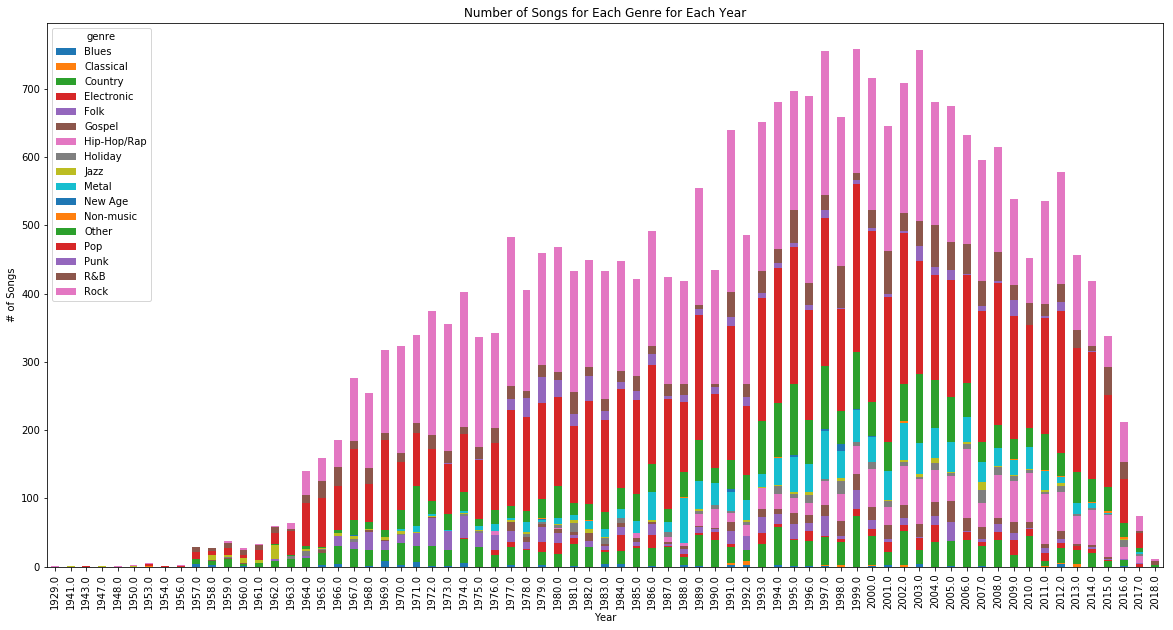

In [4]:
temp=song_df.loc[:,['release_date', 'genre', 'song']].dropna()
temp=temp.groupby(['release_date', 'genre']).count()['song']
temp.unstack('genre').plot.bar(stacked=True, figsize=(20,10))
plt.title('Number of Songs for Each Genre for Each Year')
plt.xlabel('Year')
plt.ylabel('# of Songs')
plt.savefig('../Figures/genre_byyear.pdf')

The following is a 100% stacked bar (standardized by number of songs per year). We can use this to see if the genre sampling was uniform across the years.

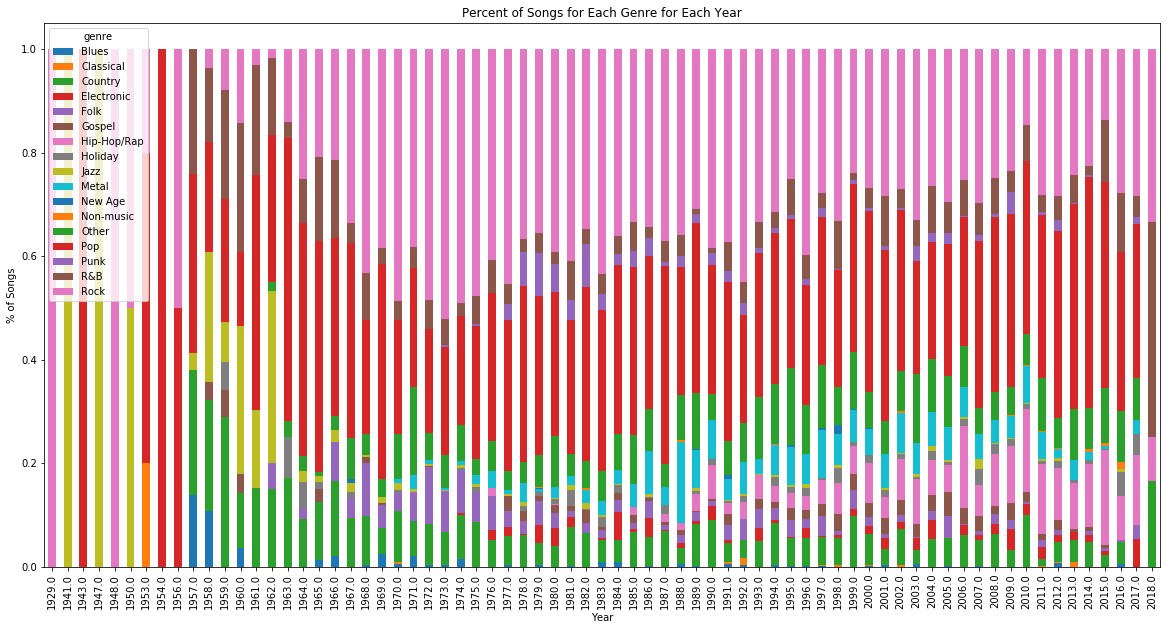

In [5]:
temp=song_df.loc[:,['release_date', 'genre', 'song']].dropna()
songs_for_year=Counter(temp.release_date.dropna())
temp=temp.groupby(['release_date', 'genre']).count()['song']

temp=temp.astype(float)
for i,x in temp.iteritems():
    temp.set_value(i, float(x/songs_for_year[i[0]]))


temp.unstack('genre').plot.bar(stacked=True, figsize=(20,10))
plt.title('Percent of Songs for Each Genre for Each Year')
plt.xlabel('Year')
plt.ylabel('% of Songs')
plt.show()

### Artist by Year
We breifly observe the most common artists each year. The results should include some of the most popular artists of each time period.

In [6]:
pd.set_option('display.max_colwidth', 500)
temp=song_df.loc[:,['release_date','artist']].dropna()
temp['release_date']=temp.release_date.astype(int)
temp.groupby(['release_date']).agg({'artist': lambda x: [y[0] for y in Counter(x).most_common(10)]})

,artist
release_date,
1929,[Louis Armstrong]
1941,[Vera Lynn]
1943,[Nat King Cole]
1947,[Nat King Cole]
1948,[Nat King Cole]
1950,"[Nat King Cole, Louis Armstrong]"
1953,"[Tom Lehrer, Ray Charles]"
1954,[Perry Como]
1956,"[Chuck Berry, Frankie Laine]"


## Profanity

Let us observe how the use of profanity has changed over the years. In general, we expect an increase over time. This analysis is included in a separate notebook as it contains explicit content. See "2.1 Profanity.ipynb". (Warning NSFW)

## Repetition
Another aspect of music that has changed is the complexity or repetitiveness of lyrics. It has been suggested that repetitive lyrics are more catchy and thus become more popular. But how do we go about measuring repetitiveness? One metric, used by Colin Moris in his online visual essay (https://pudding.cool/2017/05/song-repetition/), relates compressablility to complexity. The Lempel-Ziv algorithm is a data compression algorithm which consists of compressing repeated strings. We therefore define the Lempel-Ziv complexity as the size of the compressed data as a percent of the original. A highly repetitive song would therefore be more compressed and thus have lower complexity.

In [7]:
#https://rosettacode.org/wiki/LZW_compression

def compress(uncompressed):
    """Compress a string to a list of output symbols."""
 
    # Build the dictionary.
    dictionary = {x: ord(x) for x in list(uncompressed)}
    max_idx=max(dictionary.values())

    w = ""
    result = []
    for c in uncompressed:
        wc = w + c
        if wc in dictionary:
            w = wc
        else:
            result.append(dictionary[w])
            # Add wc to the dictionary.
            dictionary[wc] = max_idx+1
            max_idx += 1
            w = c
 
    # Output the code for w.
    if w:
        result.append(dictionary[w])
    return result

def compression_complexity(text):
    return len(compress(text))/len(text)

In [8]:
song_df['complexity']=[compression_complexity(x) if type(x)==str else None for x in song_df.lyrics]

We can see that most lyrics can be compressed quite a lot (mean of about 40% complexity). In general, complexity is normally distributed across the songs in our sample.

count    56148.000000
mean         0.384381
std          0.050206
min          0.146991
25%          0.349871
50%          0.383178
75%          0.418310
max          0.590264
Name: complexity, dtype: float64


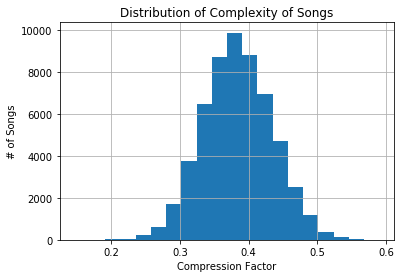

In [15]:
print(song_df.complexity.describe())
song_df.complexity.hist(bins=20)
plt.xlabel('Compression Factor')
plt.title('Distribution of Complexity of Songs')
plt.ylabel('# of Songs')
plt.savefig('../Figures/complexity.pdf')

The following figure shows the decrease in complexity of the years. Given the lack of data prior to 1970 and later than 2017, we will ignore these songs when observing the change over time.

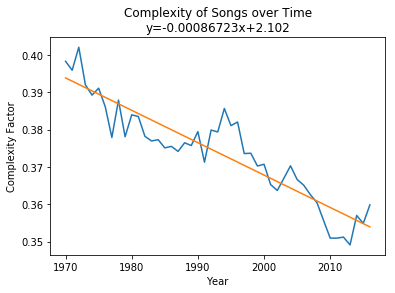

In [10]:
temp=song_df.query("release_date>=1970 & release_date<2017").groupby('release_date').mean()['complexity']
plt.plot(temp.index,temp)
slope, intercept, r_value, p_value, std_err = linregress(temp.index,temp)
plt.plot(temp.index,[slope*x + intercept for x in temp.index])
line_eq='y={}x+{}'.format(round(slope,8),round(intercept,3))
plt.title('Complexity of Songs over Time\n{}'.format(line_eq))
plt.xlabel('Year')
plt.ylabel('Complexity Factor')
plt.savefig('../Figures/complexity_overtime.pdf')

We can also look at complexity by genre:

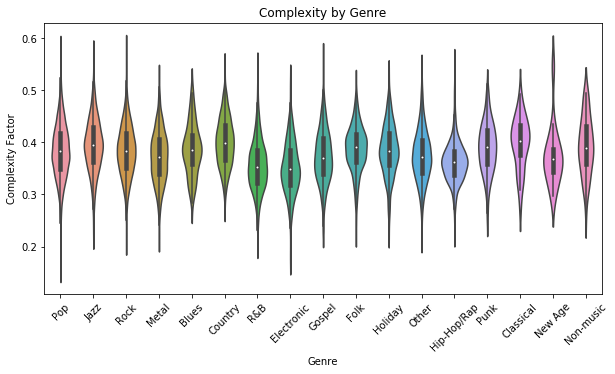

In [11]:
plt.subplots(figsize=(10,5))
sns.violinplot('genre','complexity', data=song_df)
plt.xticks(rotation=45)
plt.title('Complexity by Genre')
plt.xlabel('Genre')
plt.ylabel('Complexity Factor')
plt.savefig('../Figures/complexity_bygenre.pdf')

In [14]:
song_df.groupby('genre').mean()['complexity'].sort_values()

genre
Electronic     0.351863
R&B            0.356266
Hip-Hop/Rap    0.362982
Metal          0.372398
Gospel         0.372836
New Age        0.374397
Other          0.374535
Pop            0.384239
Rock           0.384442
Holiday        0.385166
Blues          0.386909
Folk           0.388226
Punk           0.390207
Jazz           0.393948
Non-music      0.394063
Classical      0.398853
Country        0.400408
Name: complexity, dtype: float64

In [24]:
song_df.to_csv('../Data/songdata_v2.csv',sep=',', encoding='utf-8' )